In [78]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Fair Value Gaps is a concept from price action and smart money trading theory. Is a price imbalance or inefficiency that occurs when price moves too quickly, creating a gap between candles that didn't get filled with enough buying or selling activity. When a Fair Value Gap (FVG) is respected, price typically continues in the direction of the prevailing trend. However, if the FVG is violated — a situation often referred to as an Inverse Fair Value Gap (IFVG) — it may signal a reversal, with price moving in the opposite direction of the original trend.

In [ ]:
TICKER = 'SPY'
LOOKBACK = 10000

def get_data():
    df = yf.download(TICKER)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[-LOOKBACK:,:]

def bull_fvg(df):
    # The low price of today > high price two candles ago
    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Bull_FVG'] * (df['Low'] - df['High_2prev'])) / df['Close']

    FVGs = df[df['Bull_FVG_Val'] > 0] 

    plt.hist(FVGs['Bull_FVG_Val'], bins = 10)
    plt.title('Bullish FVG Values')

    return df

def bear_fvg(df):
    # The high price of today < low price two candles ago
    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['Bear_FVG'] * (df['High'] - df['Low_2prev'])) / df['Close']

    FVGs = df[df['Bear_FVG_Val'] < 0] 

    plt.figure()
    plt.hist(FVGs['Bear_FVG_Val'], bins = 10)
    plt.title('Bearish FVG Values')

    return df


1) To assess the effectiveness of the FVG-based trading strategy, we define a holding period—the number of days we hold a position after an FVG signal appears. For each FVG detected, we calculate the asset's return over the subsequent n days (where n is the holding period).

Then, we compute the average return across all bullish or bearish FVG signals. This helps us evaluate whether, on average, entering trades at these points provides a statistically meaningful edge.

By doing this, we can answer questions like:

"Do bullish FVGs tend to precede upward price movement?"

"Are bearish FVGs followed by consistent declines?"

This analysis provides a first step in validating whether FVGs can be used as part of a systematic trading strategy.

2) After that we can ask ourselves: Are FVGs that occur within the middle range of volume more effective than the rest?

The idea is to filter out extremely high- or low-volume days and isolate those with average trading activity, which may reflect more stable and reliable market behavior.

You can see the code and the results by yourself.

In [ ]:
HOLDING_PERIOD = 5

def asses_bullish_fvg(df, holding_period = HOLDING_PERIOD):

    # Calculates the future return over the next 'holding_period' days starting from today
    df[f'Returns_In_{holding_period}P_Ago'] = df['Close'].shift(-holding_period) / df['Close'] 

    FVGs = df[df['Bull_FVG_Val'] > 0] # Only the Bull FVG
    print(f'{len(FVGs)} trades taken') #How many trades were taken

    # Average return "holding_period" days after a FVG
    print(f'Bullish FVG {holding_period} Period Average Return: {round((FVGs[f'Returns_In_{holding_period}P_Ago'].mean() - 1) * 100,2)} %')

    # 2) Filter FVGs within the middle 50% value range
    lower = FVGs['Bull_FVG_Val'].quantile(0.25)
    upper = FVGs['Bull_FVG_Val'].quantile(0.75)

    fvg_medium_val = FVGs[(FVGs['Bull_FVG_Val'] >= lower) & (FVGs['Bull_FVG_Val'] <= upper)]
    print(f'{len(fvg_medium_val)} Medium Sized Bull FVGs')
    print(f'Medium Sized Bull FVG {holding_period} Period Average Return: {round((fvg_medium_val[f'Returns_In_{holding_period}P_Ago'].mean() - 1) * 100,2)} %')

    return df

def asses_bearish_fvg(df, holding_period = HOLDING_PERIOD):

    # Calculates the future return over the next 'holding_period' days starting from today
    df[f'Returns_In_{holding_period}P_Ago'] = df['Close'].shift(-holding_period) / df['Close'] 

    FVGs = df[df['Bear_FVG_Val'] < 0]
    print(f'{len(FVGs)} trades taken')
    print(f'Bearish FVG {holding_period} Period Average Return: {round((FVGs[f'Returns_In_{holding_period}P_Ago'].mean() - 1) * 100, 2)} %')

    # 2) Filter FVGs within the middle 50% value range
    lower = FVGs['Bear_FVG_Val'].quantile(0.25)
    upper = FVGs['Bear_FVG_Val'].quantile(0.75)

    fvg_medium_val = FVGs[(FVGs['Bear_FVG_Val'] >= lower) & (FVGs['Bear_FVG_Val'] <= upper)]
    print(f'{len(fvg_medium_val)} Medium Sized Bear FVGs')
    print(f'Medium Sized Bear FVG {holding_period} Period Average Return: {round((fvg_medium_val[f'Returns_In_{holding_period}P_Ago'].mean() - 1) * 100,2)} %')

    return df



C:\Users\Ferna\AppData\Local\Temp\ipykernel_18152\3176138203.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER)
[*********************100%***********************]  1 of 1 completed

1660 trades taken
Bullish FVG 5 Period Average Return: 0.1 %
830 Medium Sized Bull FVGs
Medium Sized Bull FVG 5 Period Average Return: 0.08 %
1009 trades taken
Bearish FVG 5 Period Average Return: 0.46 %
505 Medium Sized Bear FVGs
Medium Sized Bear FVG 5 Period Average Return: 0.36 %


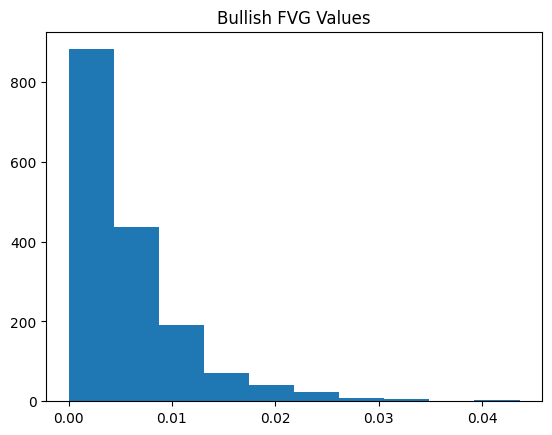

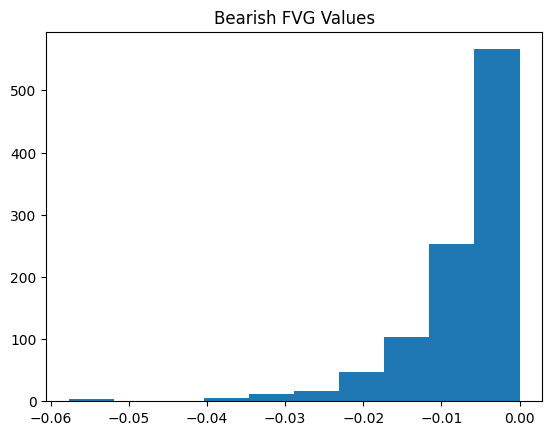

In [81]:
def main():
    df = get_data()
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = asses_bullish_fvg(df)
    df = asses_bearish_fvg(df)

    return df

df = main()